In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
plt.style.use('ggplot')

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.metrics import classification_report
import random
from collections import defaultdict,Counter

In [2]:
df2011raw = pd.read_csv('E:\Github\MLN\FinalData/2011raw.csv')
dfgraph = pd.read_csv('E:\Github\MLN\FinalData/GraphProp.csv')
dfcensus = pd.read_csv('E:\Github\MLN\FinalData/census.csv')

In [3]:
df2011raw.columns

Index(['Area Name', 'Last residence', 'Total migrants Persons',
       'Total migrants Males', 'Total migrantsFemales',
       'Work/employment Persons', 'Work/employment Males',
       'Work/employment Females', 'Business Persons', 'Business Males',
       ...
       'Unnamed: 16368', 'Unnamed: 16369', 'Unnamed: 16370', 'Unnamed: 16371',
       'Unnamed: 16372', 'Unnamed: 16373', 'Unnamed: 16374', 'Unnamed: 16375',
       'Unnamed: 16376', 'Unnamed: 16377'],
      dtype='object', length=16378)

In [26]:
def nonconnectednodes(G):
    n = G.nodes()
    un = set()
    for i in n:
        for j in n:
            x = (i,j)
            if i!=j and not G.has_edge(*x) and x not in un:
                un.add(x)
    return list(un)

In [27]:
def commonNeighbours(un, G):
    un_cn = {}
    for i in un:
        un_cn[i] = list(set(G[i[0]]).intersection(set(G[i[1]])))
    return un_cn

## Weighted Similarity Indices Based on Local Information

In [28]:
def measure(g, a=1):
    
    swcn = {}
    swaa = {}
    swra = {}
    for i in un:
        swcn[i] = 0
        swaa[i] = 0
        swra[i] = 0

        for j in uncn[i]:
            try:
                x = g[i[0]][j]['weight'] ** a
            except:
                x = 1
            try:
                y = g[j][i[0]]['weight'] ** a
            except:
                y = 1
            swcn[i]+= (x + y) 
            swaa[i]+= ((x+y)/(np.log10(1+ sum([g[j][k]['weight']for k in g[j]]))))
            swra[i]+= ((x+y)/(sum([g[j][k] ['weight'] for k in g[j]])))
    return swcn, swaa, swra

## Weighted Mutual Information Model

In [29]:
# connected pairs
def getcondiscomp(g):
    nodes = list(g.nodes())
    con = defaultdict(int)
    dcon = defaultdict(int)
    for i in range(len(nodes)):
        for j in range(i, len(nodes)):
            common = list(set(g[i]).intersection(set(g[j])))
            for k in nodes:
                if k in common:
                    con[k]+=1
                else:
                    dcon[k]+=1
    return con, dcon

In [30]:
def measuremi(g, a=1):
    
    swcn = {}
    swaa = {}
    swra = {}
    for i in un:
        swcn[i] = 0
        swaa[i] = 0
        swra[i] = 0
        for j in uncn[i]:
            try:
                x = g[i[0]][j]['weight'] ** a
            except:
                x = 1
            try:
                y = g[j][i[0]]['weight'] ** a
            except:
                y = 1
            swcn[i]+= (x + y) * (-1 * np.log10(mt/m) + np.log10(con[j]/(con[j]+dcon[j])))
            swaa[i]+= ((x+y)/(np.log10(1+ sum([g[j][k] ['weight']for k in g[j]]))))* (-1 * np.log10(mt/m) + np.log10(con[j]/(con[j]+dcon[j])))
            swra[i]+= ((x+y)/(sum([g[j][k] ['weight'] for k in g[j]])))* (-1 * np.log10(mt/m) + np.log10(con[j]/(con[j]+dcon[j])))
            
    return swcn, swaa, swra

In [31]:
def getTrueLabels(un, G):
    y_true= []
    for i in un:
        if G.has_edge(*i):
            y_true.append(1)
        else:
            y_true.append(0)
    return y_true

In [32]:
nodes = list(g1.nodes())
mt = len(g1.edges())
m  = len(nodes)*(len(nodes)-1)/2
con, dcon = getcondiscomp(g1)

In [33]:
un   = nonconnectednodes(g1)
uncn = commonNeighbours(un, g1)
swcn, swaa, swra = measure(g1, a=1)
swcn2, swaa2, swra2 = measuremi(g1, a=1)
y_true = getTrueLabels(un, g)

In [34]:
# fpr, tpr, thresholds = roc_curve(y_true, list(un_jc.values()))
def drawgraph(swcn, swaa, swra, swcn2, swaa2, swra2):
    plt.figure(figsize=(20, 6))
    plt.subplot(121)
    lw=2
    fpr, tpr, thresholds = roc_curve(y_true, list(swcn.values()))
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,lw=lw, label=f'Common Neighbour (Area = %0.3f)' % roc_auc)

    fpr, tpr, thresholds = roc_curve(y_true, list(swaa.values()))
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,lw=lw, label=f'Adamic-Adar (Area = %0.3f)' % roc_auc)  
    # (area = %0.2f)')roc_auc[2])
    fpr, tpr, thresholds = roc_curve(y_true, list(swra.values()))
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,lw=lw, label=f'Resource allocator (Area = %0.3f)' % roc_auc)


    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic of 75% Graph')
    plt.legend(loc="lower right")
    plt.subplot(122)
    # fpr, tpr, thresholds = roc_curve(y_true, list(un_jc.values()))
    lw=2
    fpr, tpr, thresholds = roc_curve(y_true, list(swcn2.values()))
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,lw=lw, label=f'Common Neighbour (Area = %0.3f)' % roc_auc)

    fpr, tpr, thresholds = roc_curve(y_true, list(swaa2.values()))
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,lw=lw, label=f'Adamic-Adar (Area = %0.3f)' % roc_auc)  
    # (area = %0.2f)')roc_auc[2])
    fpr, tpr, thresholds = roc_curve(y_true, list(swra2.values()))
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,lw=lw, label=f'Resource allocator (Area = %0.3f)' % roc_auc)


    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic of 75% Graph')
    plt.legend(loc="lower right")
    plt.show()

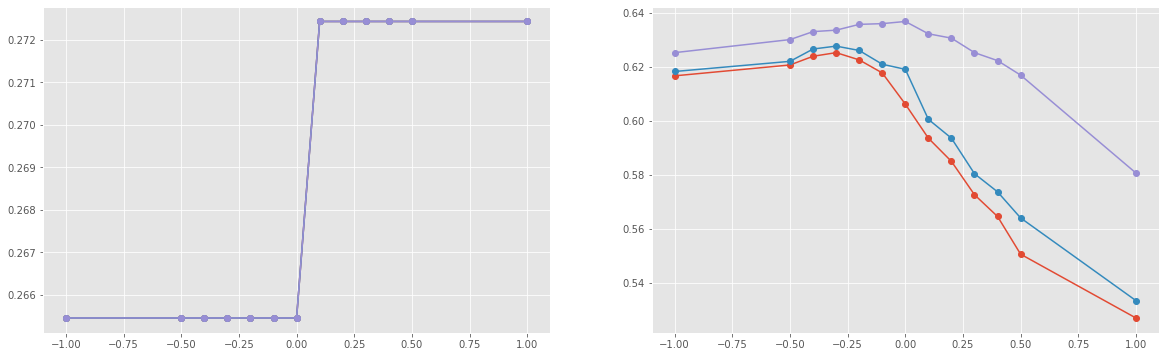

In [35]:
avalue = [-1.0, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]#-1*np.array([0,0.1,0.2,0.3,0.4,0.5,1])
scores = [[],[],[],[],[],[]]
for i in avalue:
#     print("#####################################################")
#     print("\t\t\t a = {} ".format(i))
    swcn, swaa, swra = measure(g1, a=i)
    swcn2, swaa2, swra2 = measuremi(g1, a=i)
#     drawgraph(swcn, swaa, swra, swcn2, swaa2, swra2)
    scores[0].append(roc_auc_score(y_true, list(swcn.values())))
    scores[1].append(roc_auc_score(y_true, list(swaa.values())))
    scores[2].append(roc_auc_score(y_true, list(swra.values())))
    scores[3].append(roc_auc_score(y_true, list(swcn2.values())))
    scores[4].append(roc_auc_score(y_true, list(swaa2.values())))
    scores[5].append(roc_auc_score(y_true, list(swra2.values())))
#     print("#####################################################")
plt.figure(figsize=(20, 6))
plt.subplot(121)
for i in scores[:3]:
    plt.plot(avalue, i,'-o')

plt.subplot(122)
for i in scores[3:]:
    plt.plot(avalue, i,'-o')
plt.label['']
plt.show()

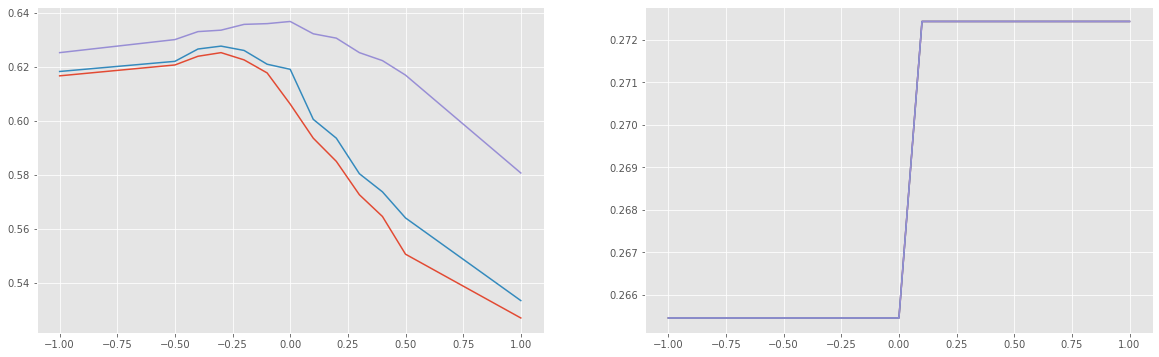

In [36]:
plt.figure(figsize=(20, 6))
plt.subplot(121)
for i in scores[3:]:
    plt.plot(avalue, i)
plt.subplot(122)
for i in scores[:3]:
    plt.plot(avalue, i)

plt.show()

In [53]:
def main(column):    
    top5 = df2011raw.groupby('Area Name')[column].apply(lambda grp: grp.nlargest(10)).index
    top5data = []
    for i in top5:
        top5data.append([df2011raw['Last residence'].loc[i[1]], i[0], df2011raw[column].loc[i[1]]])
    t = pd.DataFrame(top5data, columns=['Source', 'Target','Weight'])
    t.Source = t.Source.apply(lambda x: x+'_out')
    t.Target = t.Target.apply(lambda x: x+'_in')
    allstates = list(set(t['Source'].unique().tolist()) | set(t['Target'].unique().tolist()))
    le = LabelEncoder()
    le.fit(allstates)
    t['Source'] = le.transform(t['Source'])
    t['Target'] = le.transform(t['Target'])
    a1 = t['Source']
    b = t['Target']
    g = nx.Graph()
    wdict = defaultdict(int)
    lp2011=[]
    for i,j,k in zip(a1, b, t['Weight'].tolist()):
        if i!=j:
            lp2011.append((i,j,k))
    g.add_weighted_edges_from(lp2011)
    orgadj = nx.to_numpy_matrix(g)
    random.shuffle(lp2011)
    train = lp2011[:int(len(lp2011) *0.9)]
    test = lp2011[int(len(lp2011) *0.9):]
    g1 = nx.Graph()
    g1.add_weighted_edges_from(train)
    nodes = list(g1.nodes())
    avalue = [-1.0, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]#-1*np.array([0,0.1,0.2,0.3,0.4,0.5,1])
    scores = [[],[],[],[],[],[]]
    for i in avalue:

        swcn, swaa, swra = measure(g1, a=i)
        swcn2, swaa2, swra2 = measuremi(g1, a=i)
    #     drawgraph(swcn, swaa, swra, swcn2, swaa2, swra2)
        scores[0].append(roc_auc_score(y_true, list(swcn.values())))
        scores[1].append(roc_auc_score(y_true, list(swaa.values())))
        scores[2].append(roc_auc_score(y_true, list(swra.values())))
        scores[3].append(roc_auc_score(y_true, list(swcn2.values())))
        scores[4].append(roc_auc_score(y_true, list(swaa2.values())))
        scores[5].append(roc_auc_score(y_true, list(swra2.values())))

    plt.figure(figsize=(20, 6))
    plt.gca().set_title('Column: {}'.format(column))
    plt.subplot(121)
    for i in scores[:3]:
        plt.plot(avalue, i,'-o')
#     plt.legend['WCN', 'WAA','WRA']
    plt.subplot(122)
    for i in scores[3:]:
        plt.plot(avalue, i,'-o')
#     plt.legend['WMI-WCN', 'WMI-WAA','WMI-WRA']
    plt.show()

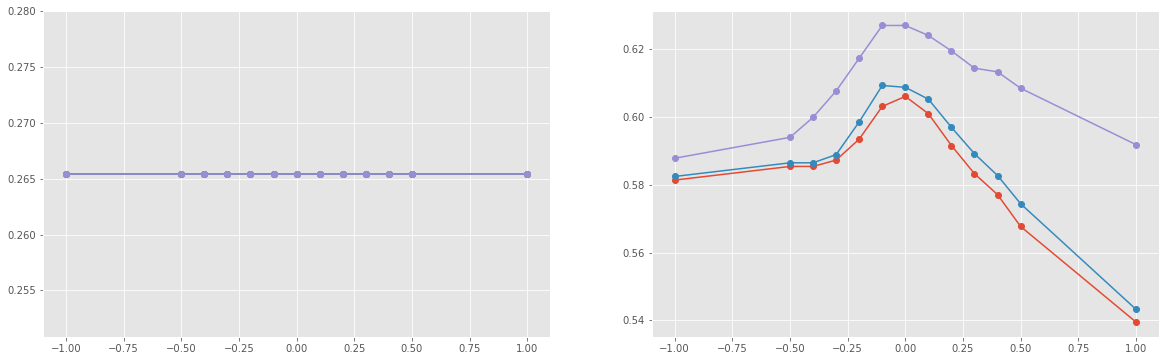

KeyError: 66

In [58]:
for column in ['Total migrants Persons', 'Work/employment Persons', 'Business Persons', 'Education Persons',  'Marriage Persons']:
    main(column)

In [56]:
df2011raw.columns[:24]

Index(['Area Name', 'Last residence', 'Total migrants Persons',
       'Total migrants Males', 'Total migrantsFemales',
       'Work/employment Persons', 'Work/employment Males',
       'Work/employment Females', 'Business Persons', 'Business Males',
       'Business Females', 'Education Persons', 'Education Males',
       'Education Females', 'Marriage Persons', 'Marriage Males',
       'Marriage Females', 'Moved after birth Persons',
       'Moved after birth Males', 'Moved after birth Females',
       'Moved with householdPersons', 'Moved with household Males',
       'Moved with household Females', 'Others Persons'],
      dtype='object')

In [ ]:
['Total migrants Persons', 'Work/employment Persons', 'Business Persons', 'Education Persons',  'Marriage Persons']